In [131]:
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import seaborn as sns
import sklearn.cluster as cluster
import time
import itertools
#from pandas_profiling import ProfileReport

import statsmodels.api as sm
import statsmodels.formula.api as smf

import math

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from matplotlib.pyplot import errorbar

#%run '../modeling/functions.py'
from modeling.functions import log_to_mlflow, modelling


# Specifing figure layout
%matplotlib inline
# plt.style.use('fivethirtyeight')
# sns.set_color_codes('bright')
# plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
# plt.rcParams["figure.figsize"] = (15, 10)

RSEED=42


In [132]:
df = pd.read_csv('../data/GEFCom2014Data/Wind/raw_data_incl_features.csv', parse_dates=['TIMESTAMP'])
df.TARGETVAR = df.TARGETVAR.fillna(0)
df = pd.get_dummies(df, columns=['WD100CARD'], drop_first=True)

In [133]:
df.columns

Index(['ZONEID', 'TIMESTAMP', 'TARGETVAR', 'U10', 'V10', 'U100', 'V100',
       'HOUR', 'MONTH', 'WEEKDAY', 'IS_HOLIDAY', 'WS10', 'WS100', 'WD10',
       'WD100', 'WD10CARD', 'U100NORM', 'V100NORM', 'WD100CARD_ENE',
       'WD100CARD_ESE', 'WD100CARD_N', 'WD100CARD_NE', 'WD100CARD_NNE',
       'WD100CARD_NNW', 'WD100CARD_NW', 'WD100CARD_S', 'WD100CARD_SE',
       'WD100CARD_SSE', 'WD100CARD_SSW', 'WD100CARD_SW', 'WD100CARD_W',
       'WD100CARD_WNW', 'WD100CARD_WSW'],
      dtype='object')

In [134]:
target = 'TARGETVAR'
features = [feat for feat in df.columns.to_list() if not 
            (feat in [target, 'TIMESTAMP', 'TARGETVAR', 'ZONEID'])]

data_train, data_test = train_test_split(df, test_size=0.25, 
            random_state=RSEED, stratify=df.ZONEID)

In [135]:
df.columns

Index(['ZONEID', 'TIMESTAMP', 'TARGETVAR', 'U10', 'V10', 'U100', 'V100',
       'HOUR', 'MONTH', 'WEEKDAY', 'IS_HOLIDAY', 'WS10', 'WS100', 'WD10',
       'WD100', 'WD10CARD', 'U100NORM', 'V100NORM', 'WD100CARD_ENE',
       'WD100CARD_ESE', 'WD100CARD_N', 'WD100CARD_NE', 'WD100CARD_NNE',
       'WD100CARD_NNW', 'WD100CARD_NW', 'WD100CARD_S', 'WD100CARD_SE',
       'WD100CARD_SSE', 'WD100CARD_SSW', 'WD100CARD_SW', 'WD100CARD_W',
       'WD100CARD_WNW', 'WD100CARD_WSW'],
      dtype='object')

In [136]:
features_opt = features.copy()
features_opt = []
features_opt.append(('U100NORM', 'V100NORM'))
features_opt.append(('U10', 'V10'))
features_opt.append(('HOUR', ))
features_opt.append(('MONTH', 'WEEKDAY'))
features_opt.append(('U100', 'V100'))
features_opt.append(tuple((x for x in df.columns if x.startswith('WD100CARD'))))

In [137]:
comb = []
for L in range(1, len(features_opt)+1):
    c = itertools.combinations(features_opt, L)
    for ii in c:
        comb.append([element for tupl in ii for element in tupl])
print(comb)
len(comb)


[['U100NORM', 'V100NORM'], ['U10', 'V10'], ['HOUR'], ['MONTH', 'WEEKDAY'], ['U100', 'V100'], ['WD100CARD_ENE', 'WD100CARD_ESE', 'WD100CARD_N', 'WD100CARD_NE', 'WD100CARD_NNE', 'WD100CARD_NNW', 'WD100CARD_NW', 'WD100CARD_S', 'WD100CARD_SE', 'WD100CARD_SSE', 'WD100CARD_SSW', 'WD100CARD_SW', 'WD100CARD_W', 'WD100CARD_WNW', 'WD100CARD_WSW'], ['U100NORM', 'V100NORM', 'U10', 'V10'], ['U100NORM', 'V100NORM', 'HOUR'], ['U100NORM', 'V100NORM', 'MONTH', 'WEEKDAY'], ['U100NORM', 'V100NORM', 'U100', 'V100'], ['U100NORM', 'V100NORM', 'WD100CARD_ENE', 'WD100CARD_ESE', 'WD100CARD_N', 'WD100CARD_NE', 'WD100CARD_NNE', 'WD100CARD_NNW', 'WD100CARD_NW', 'WD100CARD_S', 'WD100CARD_SE', 'WD100CARD_SSE', 'WD100CARD_SSW', 'WD100CARD_SW', 'WD100CARD_W', 'WD100CARD_WNW', 'WD100CARD_WSW'], ['U10', 'V10', 'HOUR'], ['U10', 'V10', 'MONTH', 'WEEKDAY'], ['U10', 'V10', 'U100', 'V100'], ['U10', 'V10', 'WD100CARD_ENE', 'WD100CARD_ESE', 'WD100CARD_N', 'WD100CARD_NE', 'WD100CARD_NNE', 'WD100CARD_NNW', 'WD100CARD_NW', 'WD10

63

In [138]:
rf_regr = RandomForestRegressor(max_depth=10, n_estimators=100, 
                min_samples_leaf=6, n_jobs=-1, random_state=RSEED)

In [139]:
result = []
for ff in comb:
    ff.append('WS100')
    print(ff)
    res_train, res_test = modelling(data_train=data_train, data_test=data_test, features=ff, model=rf_regr)
    result.append((ff, res_train, res_test))

['U100NORM', 'V100NORM', 'WS100']
train-RMSE/test-RMSE linear regression model for ZONE1: 0.157 0.181
train-RMSE/test-RMSE linear regression model for ZONE2: 0.127 0.143
train-RMSE/test-RMSE linear regression model for ZONE3: 0.127 0.15
train-RMSE/test-RMSE linear regression model for ZONE4: 0.151 0.176
train-RMSE/test-RMSE linear regression model for ZONE5: 0.153 0.175
train-RMSE/test-RMSE linear regression model for ZONE6: 0.157 0.179
train-RMSE/test-RMSE linear regression model for ZONE7: 0.113 0.131
train-RMSE/test-RMSE linear regression model for ZONE8: 0.141 0.165
train-RMSE/test-RMSE linear regression model for ZONE9: 0.14 0.159
train-RMSE/test-RMSE linear regression model for ZONE10: 0.173 0.201
train-RMSE/test-RMSE linear regression model for TOTAL: 0.145 0.167
['U10', 'V10', 'WS100']
train-RMSE/test-RMSE linear regression model for ZONE1: 0.147 0.174
train-RMSE/test-RMSE linear regression model for ZONE2: 0.123 0.141
train-RMSE/test-RMSE linear regression model for ZONE3: 0.1

In [141]:
results_ordered = sorted(result, key=lambda x : x[2]['TOTAL'])

In [142]:
results_ordered
results_ordered_with_dummies = results_ordered

In [143]:
feature_list = ['-'.join(x[0]) for x in results_ordered_with_dummies[:]]
rmse_list = [x[2]['TOTAL'] for x in results_ordered_with_dummies[:]]

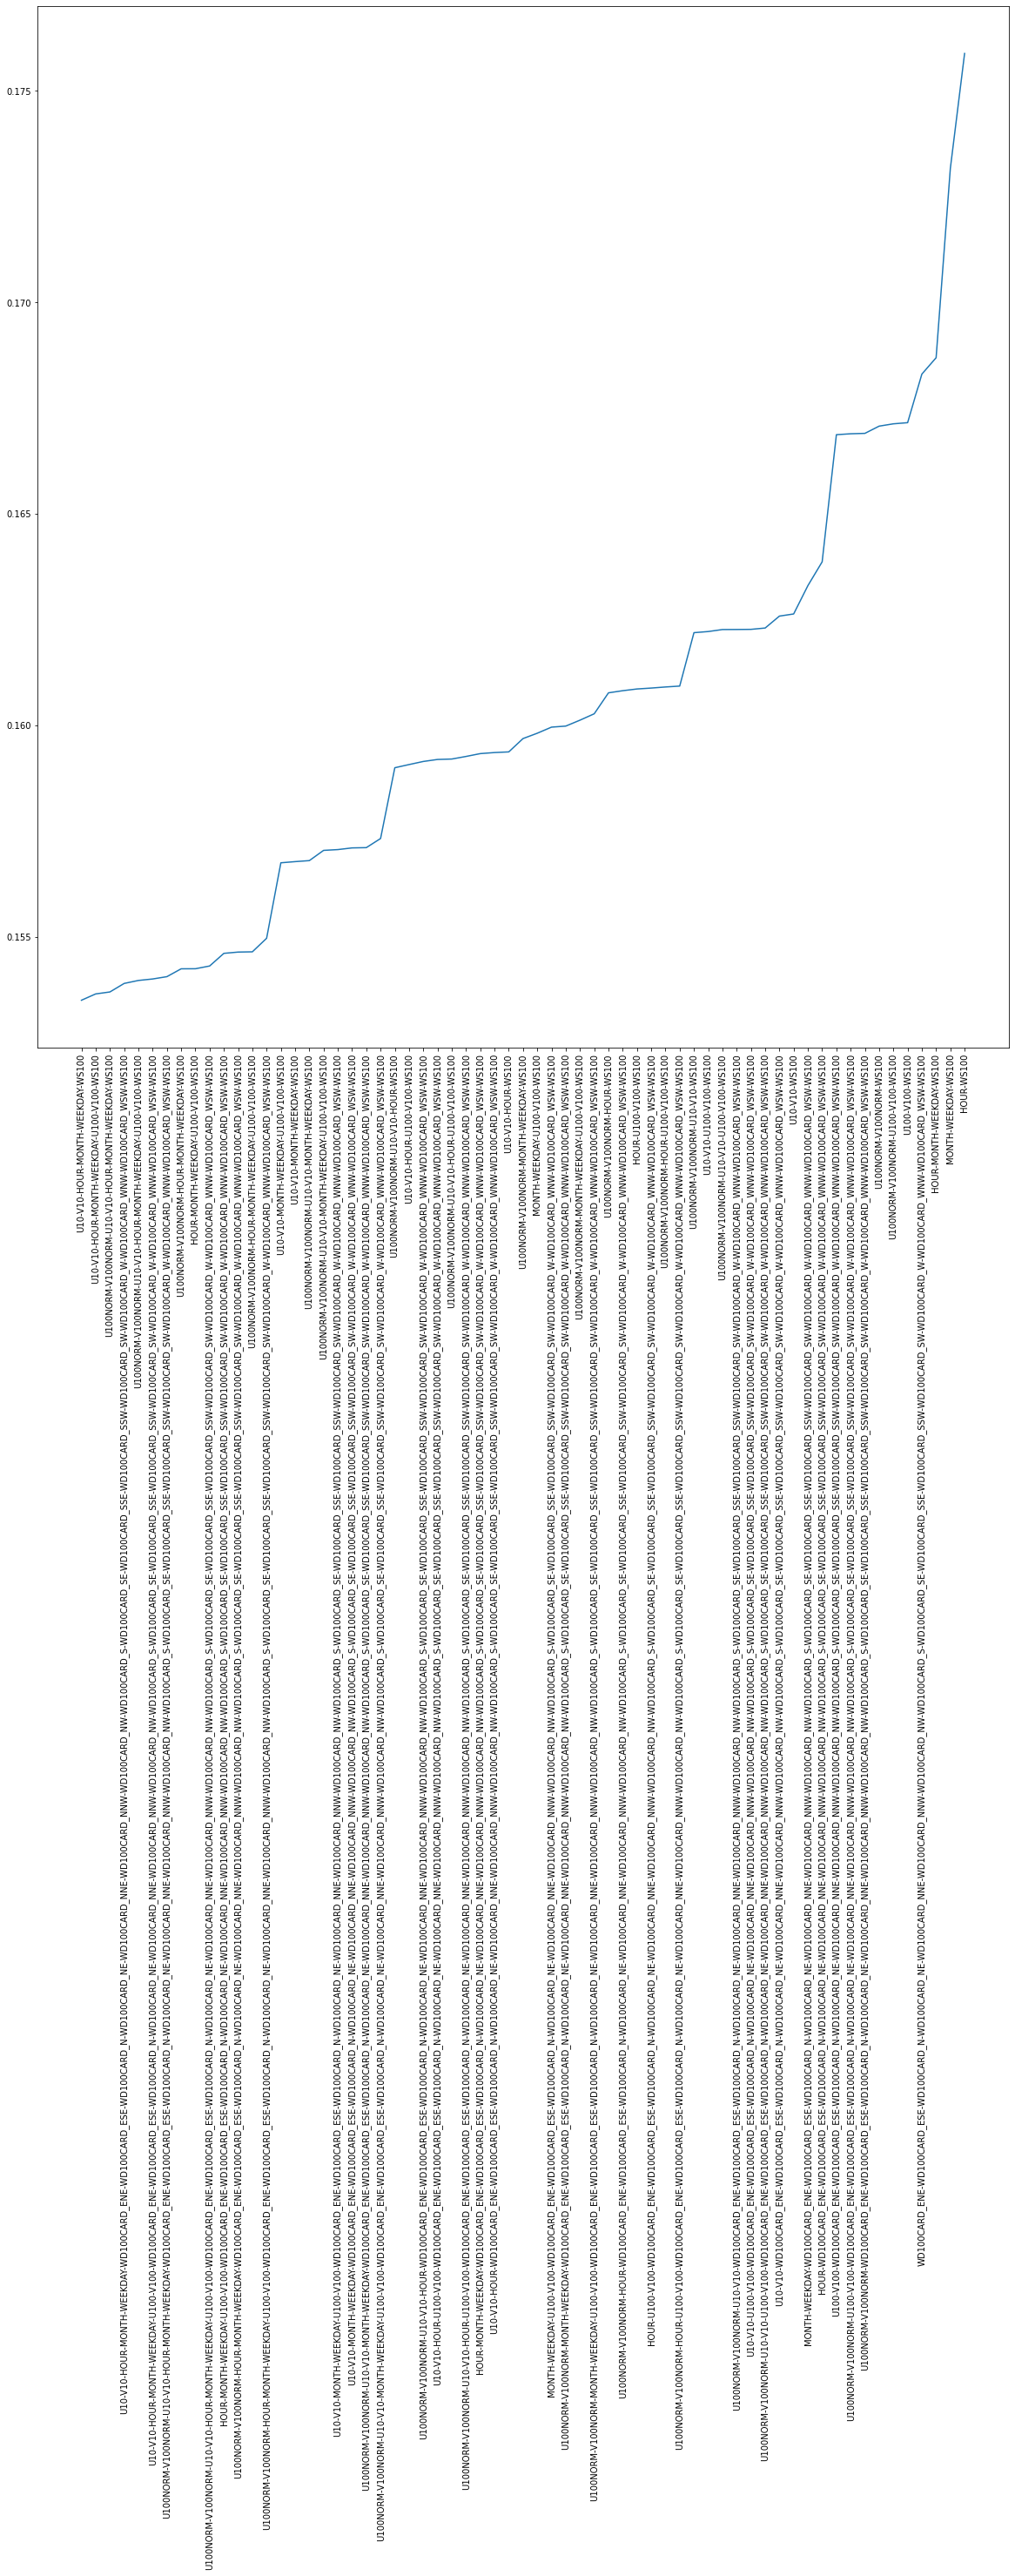

In [144]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20,22), sharex=True)#, sharey=True)
sns.lineplot(x=feature_list, y=rmse_list);
plt.xticks(rotation=90);

In [111]:
feature_list = ['-'.join(x[0]) for x in results_ordered_without_dummies[:]]
rmse_list = [x[2]['TOTAL'] for x in results_ordered_without_dummies[:]]

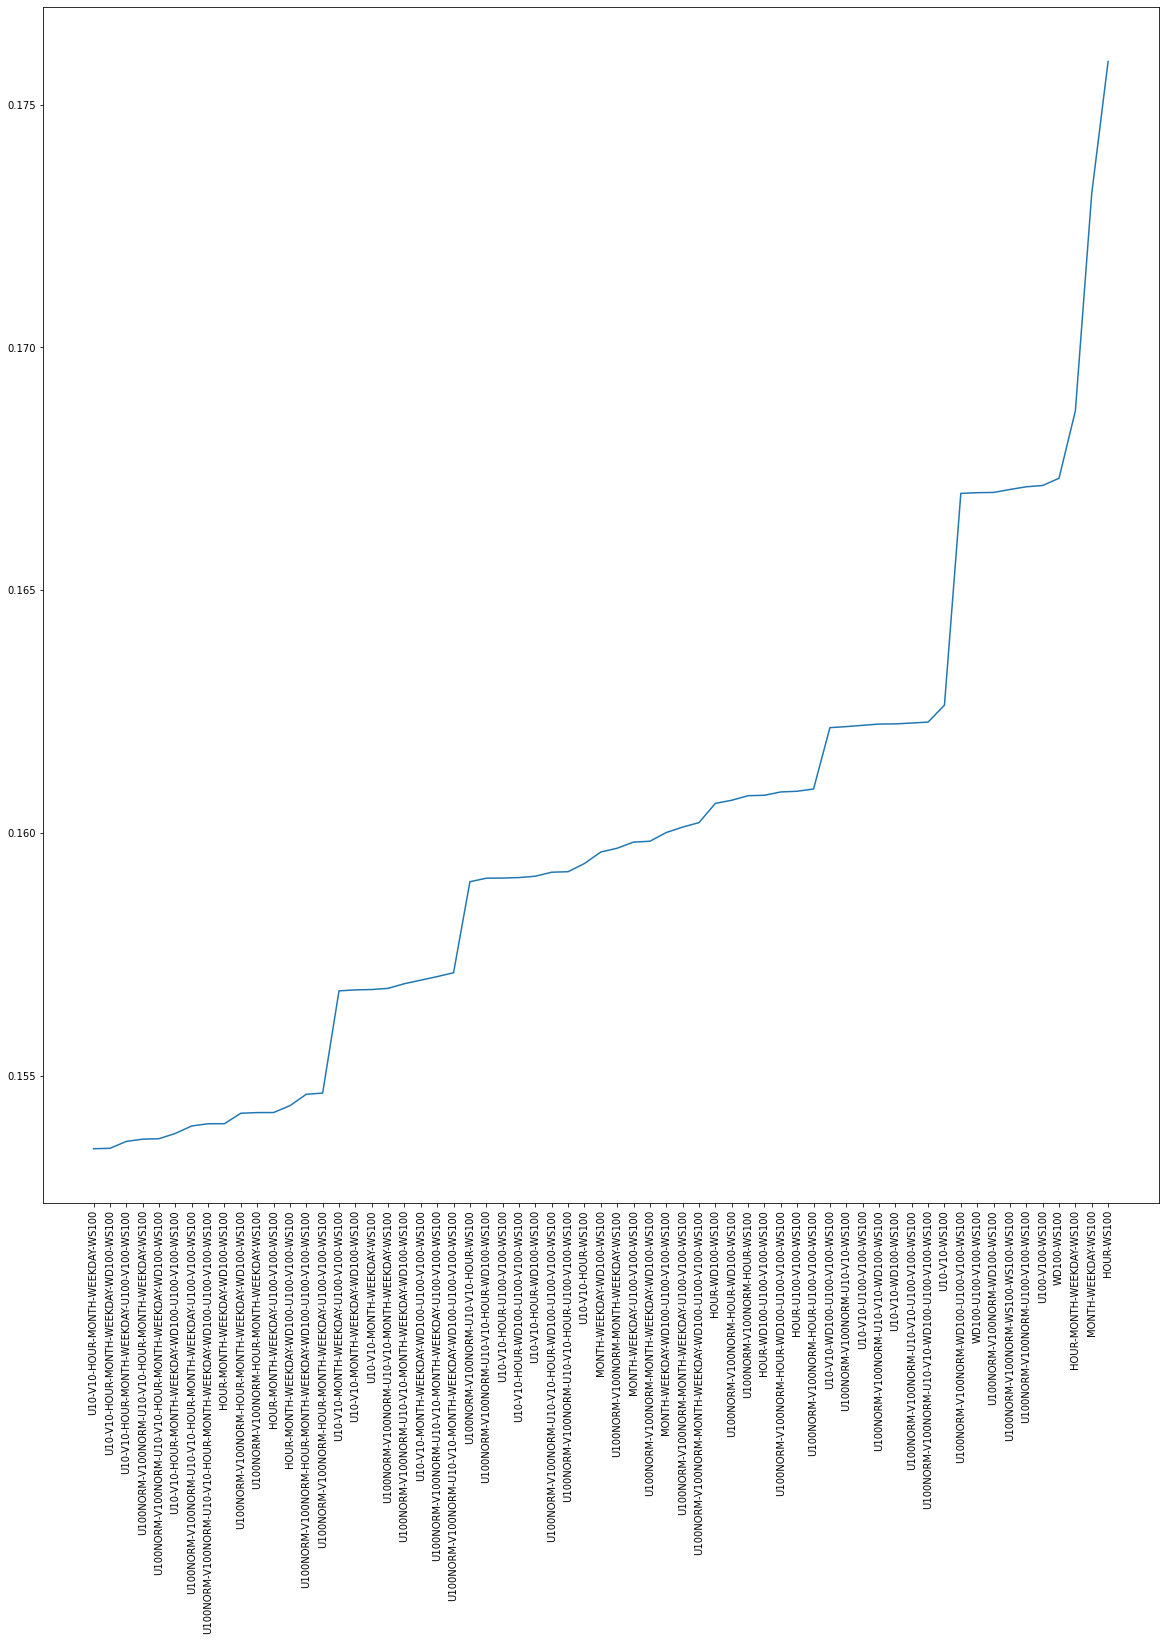

In [112]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20,22), sharex=True)#, sharey=True)
sns.lineplot(x=feature_list, y=rmse_list);
plt.xticks(rotation=90);